In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
     
from netCDF4 import Dataset 
import xarray as xr
#import Nio
import os

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap,shiftgrid,addcyclic, cm 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
# reading in the cpc precipitation data

iniyr  = 1948
endyr  = 2017
nyr    = endyr - iniyr +1

inindx = 12*(iniyr-1948)
endndx = 12*(endyr-1948+1)

ncfile2 = '/data/obs_data/CPC_CONUS/monthly/precip.V1.0.mon.mean.nc'

fprc = xr.open_dataset(ncfile2)
fprc = fprc.assign_coords(lon=((fprc.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
prc =  fprc.precip[inindx:endndx,:,:]
lon_prc  =  fprc.lon
lat_prc  =  fprc.lat 
time_prc = fprc.time[inindx:endndx]
prc.dims

('time', 'lat', 'lon')

In [3]:
# Converting  monthly precipiation to seasonal precipitation 

def annual_mean(df):
    return df.groupby('time.year').mean(dim = 'time')

prc_seas = prc.groupby('time.season').apply(annual_mean)
prc_seas = prc_seas.transpose(*['year','season','lat','lon'])
prc_seas.dims

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


('year', 'season', 'lat', 'lon')

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


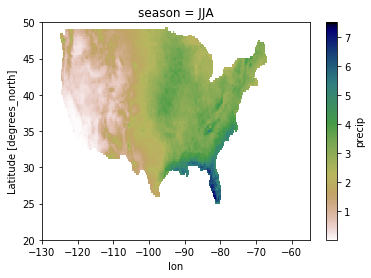

In [6]:
# plotting seasonal mean precipiation for JJA

prc_seas.sel(season='JJA').mean(dim = 'year').plot(cmap='gist_earth_r')

The above method is a fast efficient way to construct the seasonal averages, however, it only supports 4 seasons (DJF, MAM, JJA, and SON). We should also make sure that the DJF seasonal mean uses December values of the previuos year and not that of the same year.
    
I addressed these two issues by developing a new function for converting the monthly timeseries to the seasonal timeseries for any combination of three-month seasons and compared the DJF means for the two methods bellow. The results indicate that the difference between the DJF seasonal mean derived from the two different methods is zero. 

In [33]:
# Converting  monthly data to seasonal data 

def month_to_season(df,lst_seas):  # df should have the followng shape: [time, lat, lon]

    seasons = ['JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
    months  = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,11],[10,11,12],[11,12,13]]

    ntime,nlat,nlon = df.shape
    nseas = len(lst_seas)
    df_seas = xr.DataArray(np.empty((nseas,int(ntime/12),nlat,nlon)),
                           [lst_seas, df['time.year'][::12], df.lat, df.lon], dims=['season', 'year', 'lat', 'lon']) 

    for seas in lst_seas:
        if seas not in seasons: raise valueError('undefinded season {}'.format(seas))
        
        mon  = list(months[y] for y in range(len(seasons)) if seas==seasons[y])
        
        if seas == 'DJF':
            df_seas.sel(season=seas)[0,:,:]=np.array((df[0,:,:].values+df[1,:,:].values)/2)
            df_seas.sel(season=seas)[1:,:,:]=np.array((df[mon[0][0]::12,:,:][:int(ntime/12)-1,:,:].values
                                                      +df[mon[0][1]::12,:,:].values
                                                      +df[mon[0][2]::12,:,:].values)/3)

        elif seas == 'NDJ':    
            df_seas.sel(season=seas)[:int(ntime/12)-1,:,:]=np.array((df[mon[0][0]::12,:,:][:int(ntime/12)-1,:,:].values
                                                                    +df[mon[0][1]::12,:,:][:int(ntime/12)-1,:,:].values
                                                                    +df[mon[0][2]::12,:,:].values)/3)
            df_seas.sel(season=seas)[-1,:,:]=np.array((df[-1,:,:].values+df[-2,:,:].values)/2)
            
        else:
            df_seas.sel(season=seas)[:]=np.array((df[mon[0][0]::12,:,:].values
                                                     +df[mon[0][1]::12,:,:].values
                                                     +df[mon[0][2]::12,:,:].values)/3)
    return df_seas                     
    
prc_seas2 = month_to_season(prc,['DJF','MAM','JJA','SON']) 
prc_seas2 = prc_seas2.transpose(*['year','season','lat','lon'])
prc_seas2.dims

('year', 'season', 'lat', 'lon')

<xarray.DataArray ()>
array(0.0)
Coordinates:
    season   <U3 'DJF'
    year     int64 2015

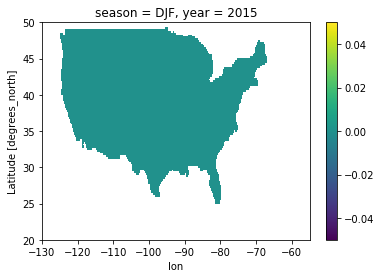

In [34]:
# plotting the difference between the two methods for DJF

diff = prc_seas.sel(season='DJF',year=2015)-prc_seas2.sel(season='DJF', year=2015)
diff.plot(vmin=-.05, vmax=.05)
diff.max()

In [35]:
# Calculating seasonal standardized anoamlies

def _standanom(var):
    return  (var - var.mean())/var.std()

def apply_standanom(da, dim):
    return xr.apply_ufunc(_standanom, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom = apply_standanom(prc_seas, 'year')

In [36]:
# detrending the seasonal standardized anomalies

def _detrend(var):
    import numpy.polynomial.polynomial as poly
    
    x = np.linspace(1,var.shape[0],var.shape[0])
    y = var.copy()
    b = ~np.isnan(y)
    
    if x[b].size ==0 :
        var_dtn = y
    else:
        coefs = poly.polyfit(x[b], y[b], 1)
        var_coef0 = coefs[0]
        var_coef1 = coefs[1]
        ffit = poly.polyval(x[b], coefs)
        var_dtn = y[b] - ffit + coefs[0]
    
    return var_dtn

def apply_detrend(da, dim):
    return xr.apply_ufunc(_detrend, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom_dtrn = apply_detrend(prc_seas_anom, 'year')

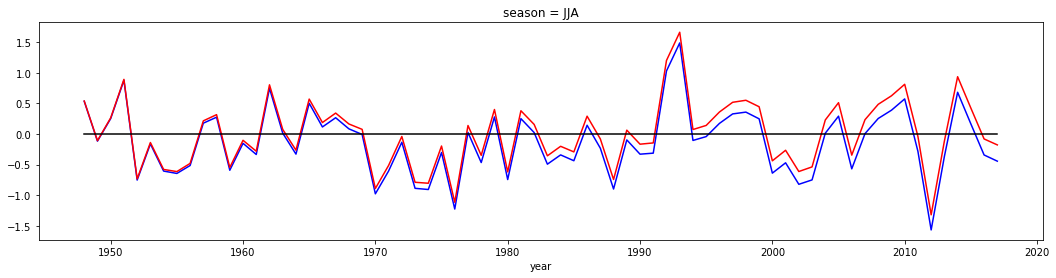

In [37]:
# defining the US GP domain boundaries    
GP = [ 35. , 47. , -105. , -95. ] # [minlat , maxlat, minlon, maxlon] 

# plotting the timeseries of standardized anomalies of summer precipiation averaged over the GP
plt.figure(figsize=(18,4))
prc_seas_anom_dtrn.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon']).plot(color='b')
prc_seas_anom.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon']).plot(color='r')

zero_ax = prc_seas_anom.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon'])
zero_ax[:] = 0.
zero_ax.plot(color='black')